<a href="https://www.kaggle.com/code/serdargundogdu/gdz-enerji-makine-renmesi-leri-xgboost?scriptVersionId=126989468" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# İş Problemi

İzmir ve Manisa illerinde günlük yaşamın vazgeçilmezi olan elektrik enerjisini, insan odaklı hizmet anlayışı ve modern teknoloji sistemleri ile tüketicilerine ulaştıran Gdz Elektrik, geleneksel hale getirdiği Datathon serisinin ikincisinin çözümüdür.

Katılımcıların sunulan veri seti ile Gdz Elektrik sorumluluğundaki şebeke merkezlerine yönelik "enerji dağıtım" tahminleme yaklaşımı geliştirilmesi bekleniyor. 🎯

Kaggle yarışmasında başarı metriği MAPE (Mean Absolute Percentage Error) olacaktır.

# Veri Seti Hikayesi

Dosya

● med.csv - Major Event Day veri seti

● train.csv - Train veri seti

● sample_submission.csv - Örnek submission dosyası

Açıklamalar

Major Event Day (MED.CSV): Gün içindeki elektrik kesinti süresinin kabul edilebilir limiti aştığı gün. Dolayısıyla kesinti olduysa o gün tahmin edilen enerjinin sapmasının yüksek olmasını bekleriz. Çünkü kesinti nedeniyle dağıtılamamış.

Dağıtılan Enerji: Watt: Aktif(yararlı) gücün birimi. MWh = MegaWatt saat

Dağıtılan Enerji'nin %85'i İzmir, %15'i ise Manisa için gerçekleştirilmektedir.

Dış Veri Kullanımı Size faydalı olabileceğini düşündüğünüz her türlü halka açık veriyi kullanabilirsiniz.

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# ÖZET

* Aykırı Değer Analizi

* Forecasting Horizon Açıklaması

* Zaman Serilerinde Cross Validation

* Lag Features

* Geleceği Tahmin Etmek

In [2]:
df = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/train.csv')
df = df.set_index('Tarih')
df.index = pd.to_datetime(df.index)

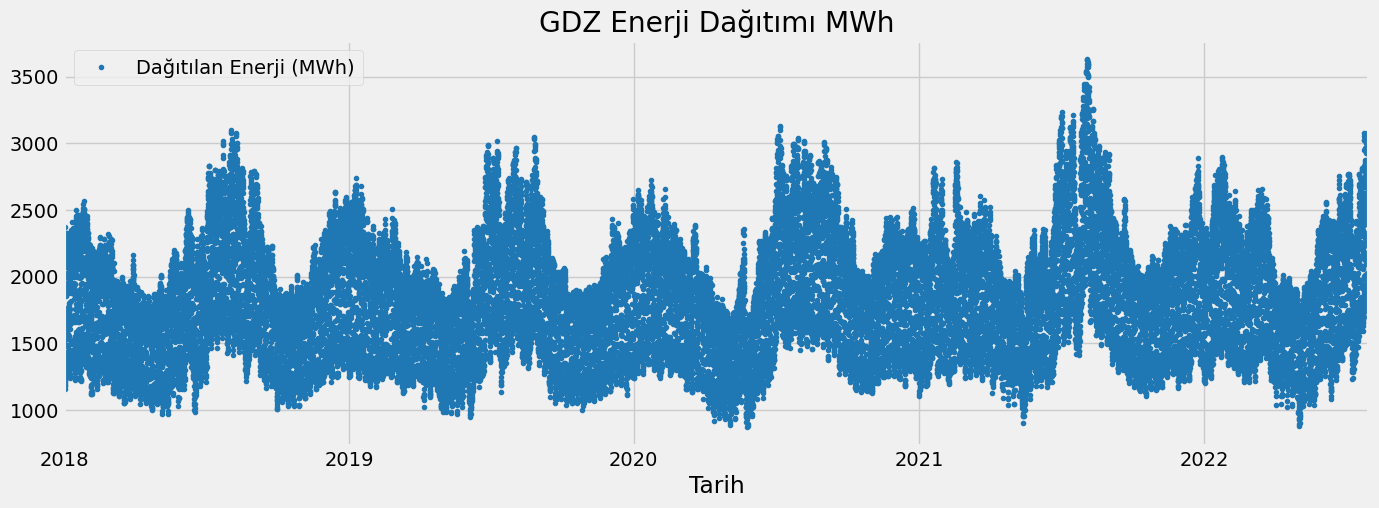

In [3]:
df.plot(style='.', 
        figsize=(15,5), 
        color=color_pal[0], 
        title='GDZ Enerji Dağıtımı MWh')
plt.show()

# 1. Aykırı Değer Analizi ve Kaldırılması

<AxesSubplot:ylabel='Frequency'>

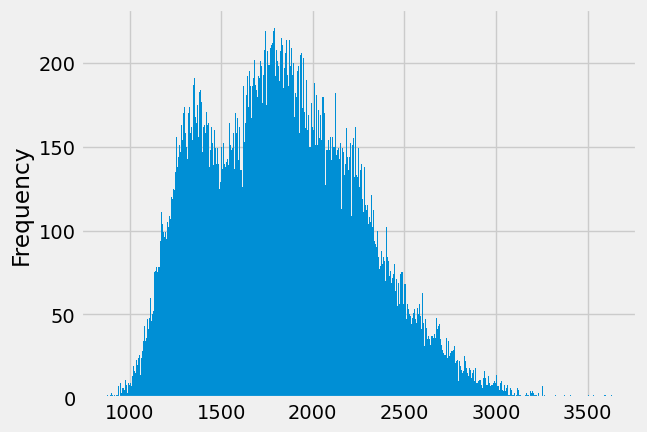

In [4]:
df['Dağıtılan Enerji (MWh)'].plot(kind='hist', bins=500)

<AxesSubplot:xlabel='Tarih'>

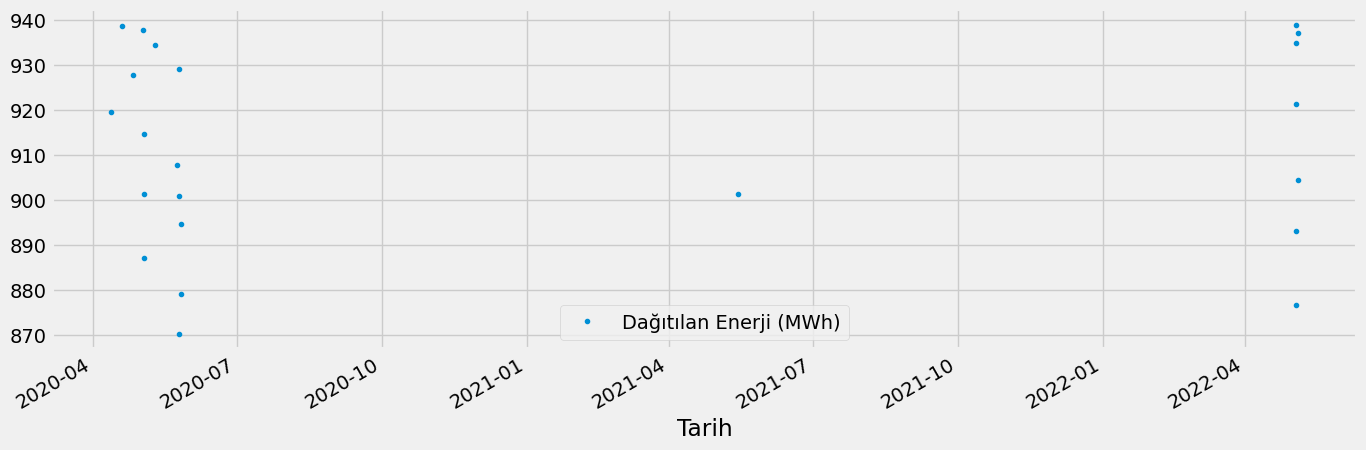

In [5]:
df.query("`Dağıtılan Enerji (MWh)` < 940").plot(figsize=(15, 5), style='.')

In [6]:
df = df.query("`Dağıtılan Enerji (MWh)` > 940").copy()

<AxesSubplot:xlabel='Tarih'>

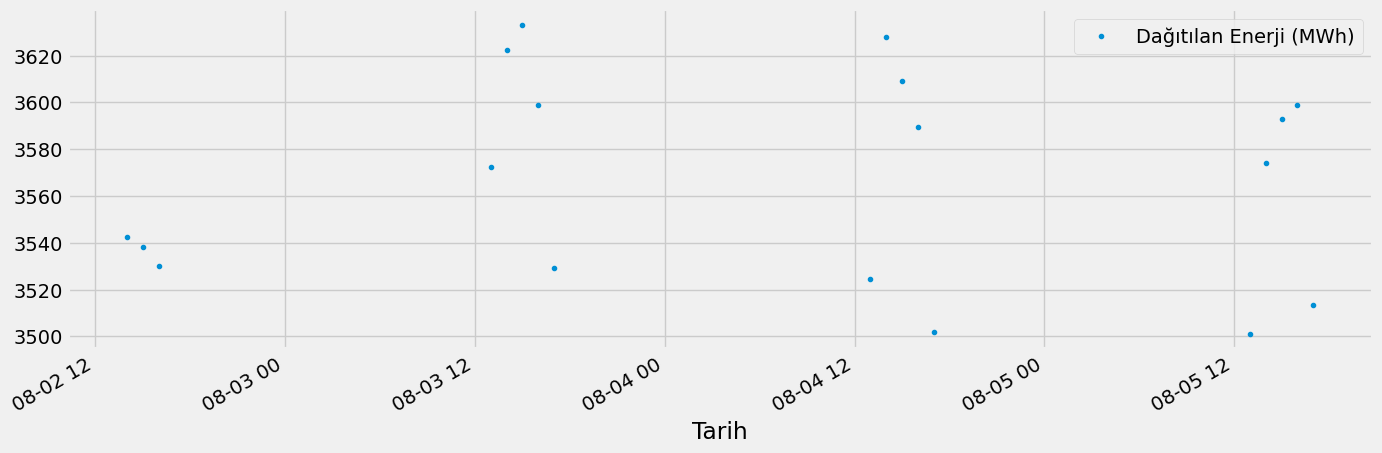

In [7]:
df.query("`Dağıtılan Enerji (MWh)` > 3500").plot(figsize=(15, 5), style='.')

In [8]:
df.shape

(40130, 1)

# Train / Test Split Gözden Geçirme

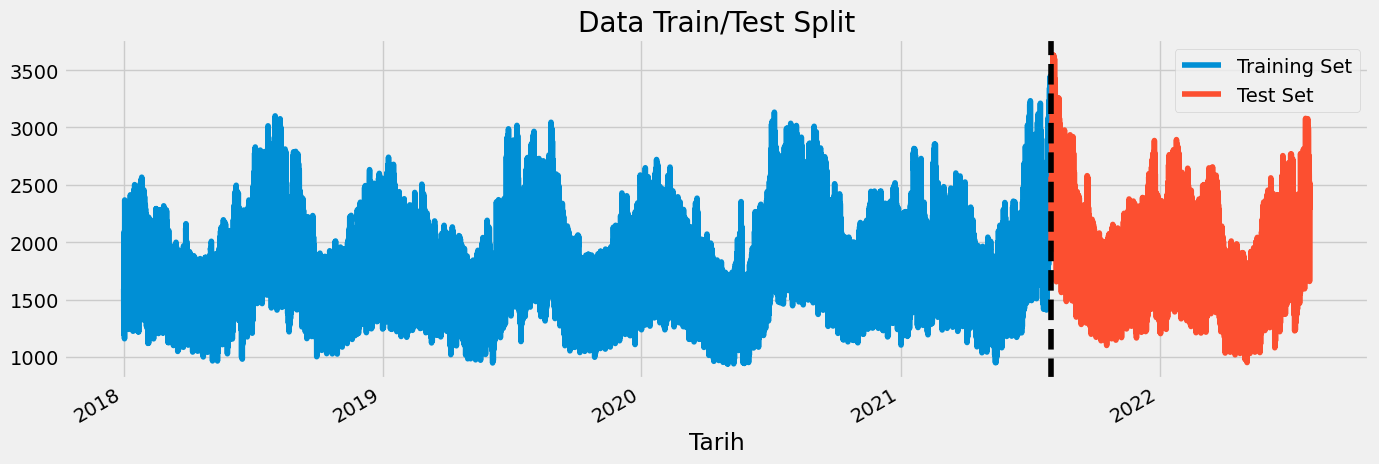

In [9]:
train = df.loc[df.index < '2021-08-01']
test = df.loc[df.index >= '2021-08-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2021-08-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# Zaman Serileri Cross Validation

In [10]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=4, test_size=24*365*1, gap=24)
df = df.sort_index()

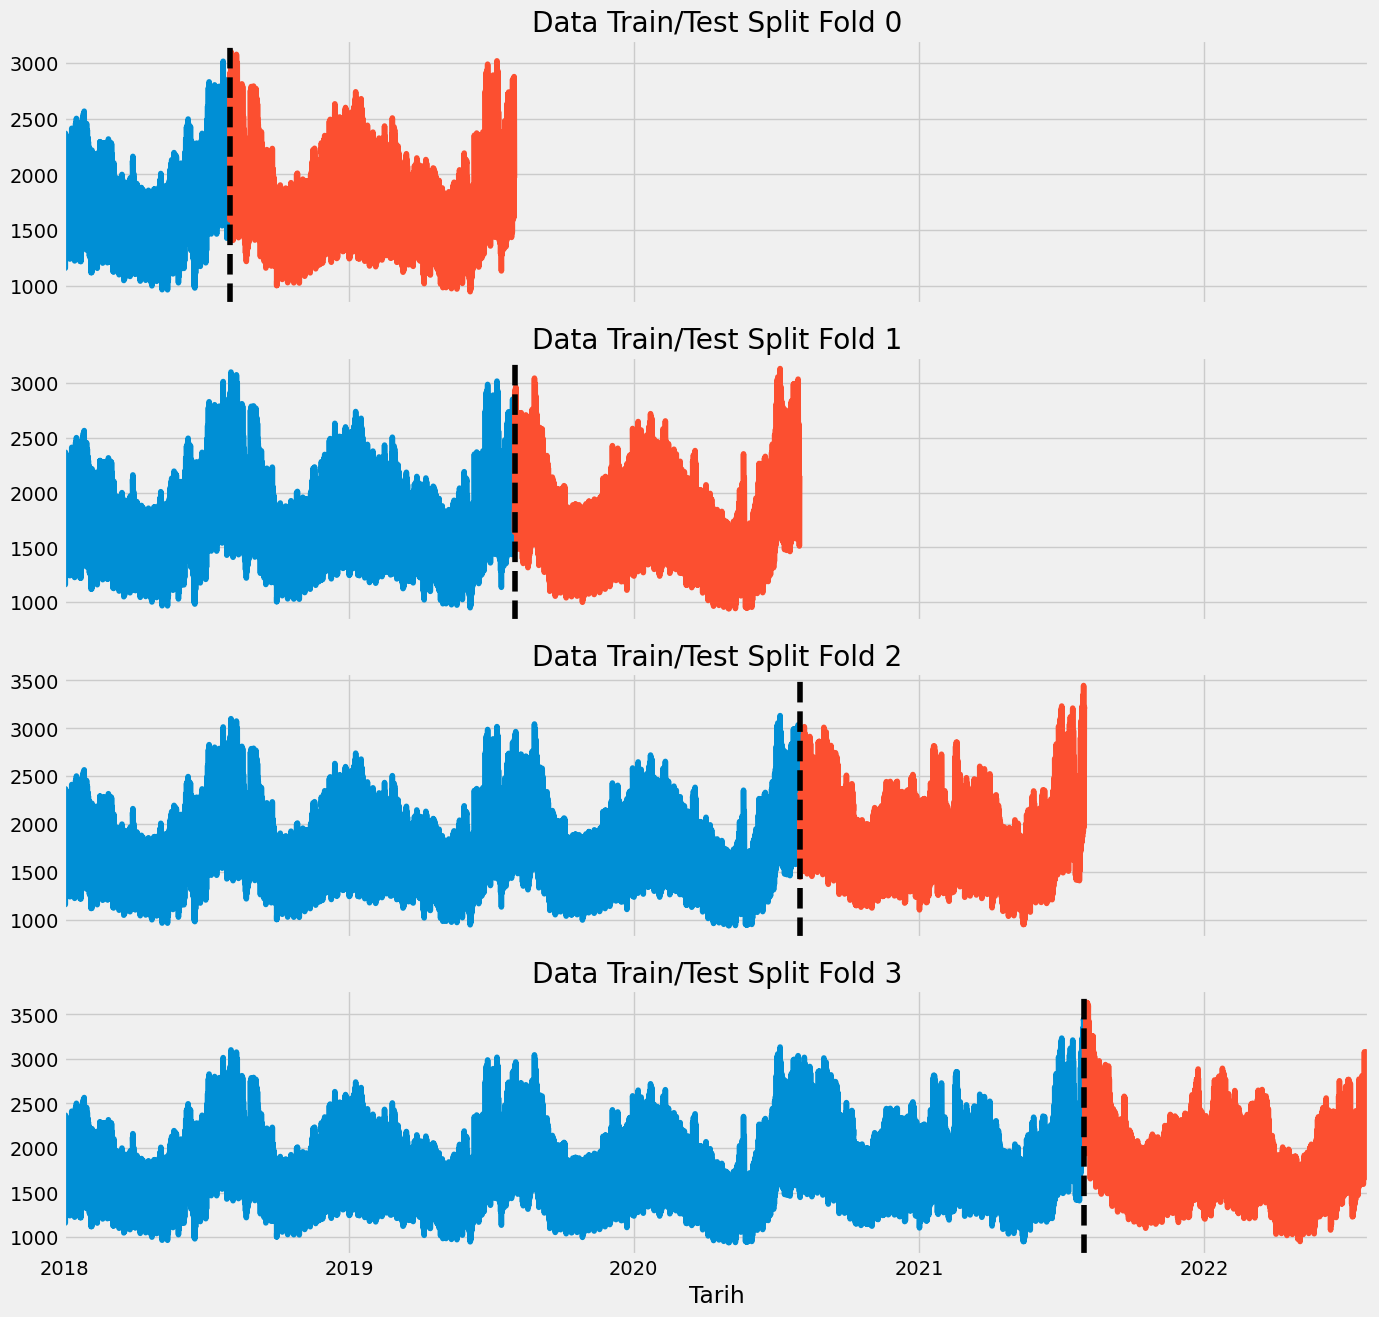

In [11]:
fig, axs = plt.subplots(4, 1, figsize=(15,15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Dağıtılan Enerji (MWh)'].plot(ax=axs[fold],
                                         label='Training Set',
                                         title=f'Data Train/Test Split Fold {fold}')
    test['Dağıtılan Enerji (MWh)'].plot(ax=axs[fold],
                                       label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold +=1
plt.show()

# 2. Forecasting Horizon Açıklaması

Ne kadar mesafeyi gelecekte tahmin edeceğimizi gösteren bir göstergedir. 3 aydan daha az ise kısa dönem ve 2 yıldan uzun ise uzun dönem olarak değişmektedir. Burada önemli nokta tahmin edeceğimiz aralıktan daha kısa bir süreye lag özelliklerini koymamaktır.

In [12]:
def create_features(df):
    """
    Create time series features based on time series index
    Festival holidays
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['iswknd'] = df.index.weekday // 4
    df['isFestival'] = 0
    df.loc[df.index.strftime('%Y-%m-%d').isin(["2018-06-14","2018-06-15","2018-06-16","2018-06-17",
                                              "2018-08-20","2018-08-21","2018-08-22","2018-08-23","2018-08-24",
                                              "2019-06-03","2019-06-04","2019-06-05","2019-06-06",
                                              "2019-08-10","2019-08-11","2019-08-12","2019-08-13","2019-08-14",
                                              "2020-05-23","2020-05-24","2020-05-25","2020-05-26",
                                              "2020-07-30","2020-07-31","2020-08-01","2020-08-02","2020-08-03",
                                              "2021-05-12","2021-05-13","2021-05-14","2021-05-15",
                                              "2021-07-19","2021-07-20","2021-07-21","2021-07-22","2021-07-23",
                                              "2022-05-01","2022-05-02","2022-05-03","2022-05-04",
                                              "2022-07-08","2022-07-09","2022-07-10","2022-07-11","2022-07-12"]),'isFestival'] = 1
    return df

df = create_features(df)

# MED(Major Event Days) Özelliği Eklenmesi

In [13]:
df_med = pd.read_csv('/kaggle/input/gdz-elektrik-datathon-2023/med.csv')
df_med = df_med.set_index('Tarih')
df_med.index = pd.to_datetime(df_med.index)

In [14]:
df.head()

,Dağıtılan Enerji (MWh),hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,iswknd,isFestival
Tarih,,,,,,,,,,,
2018-01-01 00:00:00,1593.944216,0,0,1,1,2018,1,1,1,0,0
2018-01-01 01:00:00,1513.933887,1,0,1,1,2018,1,1,1,0,0
2018-01-01 02:00:00,1402.612637,2,0,1,1,2018,1,1,1,0,0
2018-01-01 03:00:00,1278.527266,3,0,1,1,2018,1,1,1,0,0
2018-01-01 04:00:00,1220.697701,4,0,1,1,2018,1,1,1,0,0


In [15]:
df['isMed'] = 0
df.loc[df.index.strftime('%Y-%m-%d').isin(df_med.index.strftime('%Y-%m-%d')),'isMed'] = 1 

In [16]:
df.shape

(40130, 12)

In [17]:
df.head()

,Dağıtılan Enerji (MWh),hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,iswknd,isFestival,isMed
Tarih,,,,,,,,,,,,
2018-01-01 00:00:00,1593.944216,0,0,1,1,2018,1,1,1,0,0,0
2018-01-01 01:00:00,1513.933887,1,0,1,1,2018,1,1,1,0,0,0
2018-01-01 02:00:00,1402.612637,2,0,1,1,2018,1,1,1,0,0,0
2018-01-01 03:00:00,1278.527266,3,0,1,1,2018,1,1,1,0,0,0
2018-01-01 04:00:00,1220.697701,4,0,1,1,2018,1,1,1,0,0,0


# İzmir Hava Sıcaklığı Saatlik Verisi Eklenmesi

In [18]:
df_temp = pd.read_excel('/kaggle/input/izmir-2018-2022-saatlik-hava-durumu/zmirHavaData.xlsx')
df_temp = df_temp.set_index('Tarih')
df_temp.index = pd.to_datetime(df_temp.index)
df_temp = df_temp.resample('1H').mean()
df_temp = df_temp[df_temp.index < "2022-08-01"]
df_temp.dropna(axis=0,inplace=True)
df = df.merge(df_temp['Temp.'], how = 'left', right_index = True, left_index=True)

In [19]:
df.shape

(40130, 13)

# 3. Gecikme (Lag) Özellikleri

Hedef değişkenin x gün önce değeri neydi?

Buradaki gecikme tahmin edilecek mesafeden uzun olmalıdır.

In [20]:
def add_lags(df):
    target_map = df['Dağıtılan Enerji (MWh)'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map) # 364 seçildi çünkü 7 ile tam bölünebilir
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
   
    return df

df = add_lags(df)

# Cross Validation kullanarak Train

In [21]:
tss = TimeSeriesSplit(n_splits=4, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)
    
    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 
                'lag1', 'lag2', 'lag3',
                'isFestival', 'isMed','Temp.', 'iswknd']
    TARGET = ['Dağıtılan Enerji (MWh)']

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=10,
                           learning_rate = 0.01,
                           eval_metric='mape')
    reg.fit(X_train, y_train,
           eval_set=[(X_train, y_train), (X_test, y_test)],
           verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = mean_absolute_percentage_error(y_test, y_pred)
    scores.append(score)

[07:58:45] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mape:0.98967	validation_1-mape:0.98877
[100]	validation_0-mape:0.36176	validation_1-mape:0.30459
[200]	validation_0-mape:0.13282	validation_1-mape:0.14100
[300]	validation_0-mape:0.04996	validation_1-mape:0.12243
[364]	validation_0-mape:0.02852	validation_1-mape:0.12291
[07:58:49] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mape:0.98967	validation_1-mape:0.98948
[100]	validation_0-mape:0.36128	validation_1-mape:0.35218
[200]	validation_0-mape:0.13251	validation_1-mape:0.12711
[300]	validation_0-mape:0.05014	validation_1-mape:0.06948
[400]	validation_0-mape:0.02405	validation_1-mape:0.06264
[454]	validation_0-mape:0.01905	validation_1-mape:0.06283
[07:59:01] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	valid

In [22]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.0860
Fold scores:[0.12220733226217387, 0.06262230070781118, 0.09783057724798043, 0.06117924737974936]


# Geleceği Tahmin Etmek

In [23]:
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 
            'lag1', 'lag2', 'lag3',
            'isFestival', 'isMed','Temp.', 'iswknd']
TARGET = ['Dağıtılan Enerji (MWh)']

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, 
                       booster='gbtree',
                       n_estimators=1000,
                       objective='reg:linear',
                       max_depth=10,
                       learning_rate = 0.01,
                       eval_metric='mape')
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[08:00:12] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mape:0.98964
[100]	validation_0-mape:0.35981
[200]	validation_0-mape:0.13087
[300]	validation_0-mape:0.05264
[400]	validation_0-mape:0.03159
[500]	validation_0-mape:0.02530
[600]	validation_0-mape:0.02219
[700]	validation_0-mape:0.01951
[800]	validation_0-mape:0.01759
[900]	validation_0-mape:0.01605
[999]	validation_0-mape:0.01493


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='mape', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

In [24]:
df.index.max()

Timestamp('2022-07-31 23:00:00')

In [25]:
# Create future dataframe
future = pd.date_range('2022-08-01', '2022-08-31 23:00:00', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [26]:
future_w_features = df_and_future.query('isFuture').copy()

In [27]:
future_w_features

,Dağıtılan Enerji (MWh),hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,iswknd,isFestival,isMed,Temp.,lag1,lag2,lag3,isFuture
2022-08-01 00:00:00,NaN,0,0,3,8,2022,213,1,31,0,0,NaN,NaN,2599.766650,1935.462260,1941.565596,True
2022-08-01 01:00:00,NaN,1,0,3,8,2022,213,1,31,0,0,NaN,NaN,2417.310610,1817.717466,1792.989152,True
2022-08-01 02:00:00,NaN,2,0,3,8,2022,213,1,31,0,0,NaN,NaN,2265.558033,1696.164752,1675.235546,True
2022-08-01 03:00:00,NaN,3,0,3,8,2022,213,1,31,0,0,NaN,NaN,2168.612720,1632.852579,1600.905424,True
2022-08-01 04:00:00,NaN,4,0,3,8,2022,213,1,31,0,0,NaN,NaN,2095.797068,1580.401184,1564.533322,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31 19:00:00,NaN,19,2,3,8,2022,243,31,35,0,0,NaN,NaN,2465.729820,2585.969806,2313.684111,True
2022-08-31 20:00:00,NaN,20,2,3,8,2022,243,31,35,0,0,NaN,NaN,2492.323783,2628.482996,2322.690733,True
2022-08-31 21:00:00,NaN,21,2,3,8,2022,243,31,35,0,0,NaN,NaN,2356.816997,2508.054810,2206.077681,True
2022-08-31 22:00:00,NaN,22,2,3,8,2022,243,31,35,0,0,NaN,NaN,2253.909837,2369.201184,2085.464487,True


# Geleceği Tahmin Etmek

In [28]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

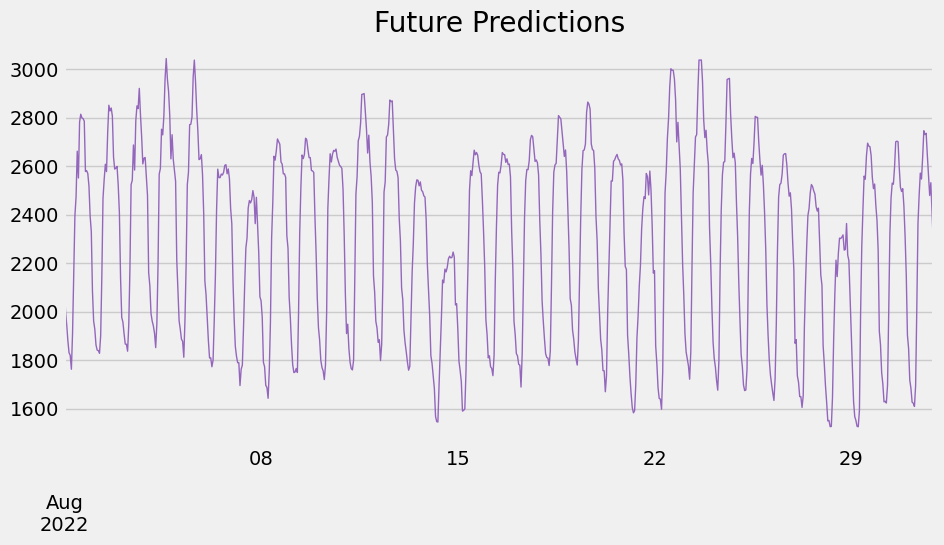

In [29]:
future_w_features['pred'].plot(figsize=(10, 5), 
                       color=color_pal[4], 
                       ms=1, 
                       lw=1, 
                       title='Future Predictions')
plt.show()

In [30]:
df_submission = future_w_features[['pred']]
df_submission.index.name = 'Tarih'
df_submission = df_submission.rename(columns={'pred':'Dağıtılan Enerji (MWh)'})
df_submission.to_csv('submission.csv')

In [31]:
df_submission

,Dağıtılan Enerji (MWh)
Tarih,
2022-08-01 00:00:00,2108.403809
2022-08-01 01:00:00,2001.243408
2022-08-01 02:00:00,1945.753906
2022-08-01 03:00:00,1880.025879
2022-08-01 04:00:00,1830.700806
...,...
2022-08-31 19:00:00,2478.848389
2022-08-31 20:00:00,2531.398193
2022-08-31 21:00:00,2410.633789


# Modeli Bir Daha Kullanmak Üzere Kaydetmek

In [32]:
reg.save_model('model.json')

# Modeli Geri Çağırmak

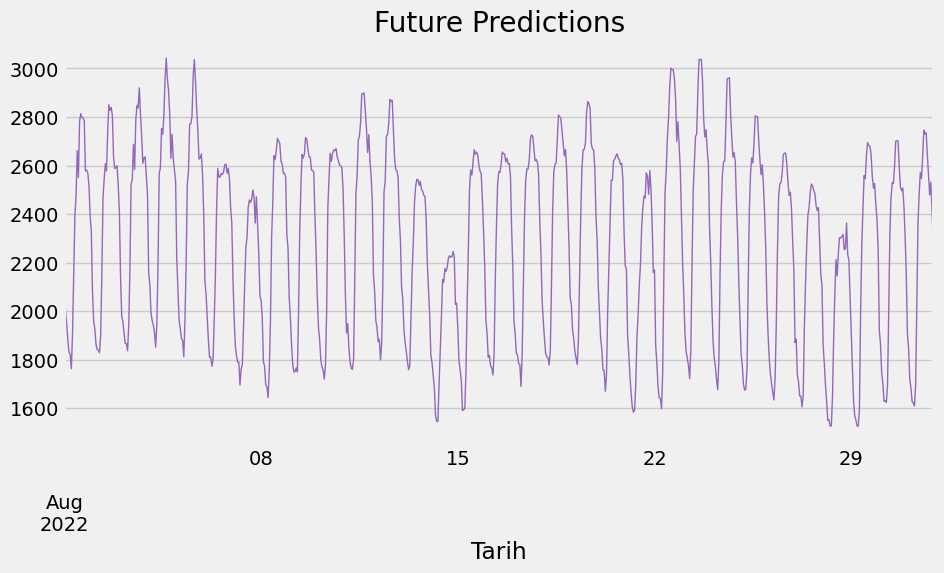

In [33]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5), 
                       color=color_pal[4], 
                       ms=1, 
                       lw=1, 
                       title='Future Predictions')
plt.show()

# Kaynakça

https://www.youtube.com/watch?v=z3ZnOW-S550&t=2s&ab_channel=RobMulla
